In [1]:

import numpy as np
import numpy.ma as ma
from astropy.table import Table
import matplotlib.pyplot as plt
from disk_mass import calc_mass_curve, fit_mass_curve
from combin_fit_functions import combination_fit
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from rotation_fitfunctions import find_phi, find_axis_ratio, chi2
import RC_plotting_functions as RC
%matplotlib inline

In [3]:
import importlib
import disk_mass
import rotation_fitfunctions
importlib.reload(disk_mass)

<module 'disk_mass' from '/gpfs/fs1/home/lstroud3/Documents/RotationCurve/2D_RC/disk_mass.py'>

In [7]:
SigD = 651.0289797724238
Rd = 0.903804192022047
rho_b =  120050641.10390615
Rb = 2.73444270675828

params = [-1.634517103582505, 7.363831777290586, 0.506337302748544, 0.6993130761460795, 36.5964126142139, 37.67240962101176, 14.097480189066221]

from rotation_fitfunctions import parameterfit_iso
testfit = parameterfit_iso(params, rho_b, Rb, SigD, Rd, scale, shape, maps['vmasked'], maps['ivarmasked'], vmap_mask)


/software/anaconda3/5.3.0/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


---------------------------------------------------
Status: 0 Values: [8.07203679e+00 2.67291154e+00 2.51149260e-05 8.02321675e-01
 3.58493021e+01 3.67390832e+01 1.40846137e+01]


TypeError: only size-1 arrays can be converted to Python scalars

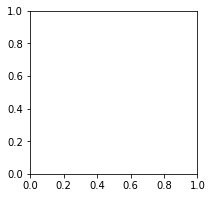

In [2]:
gal_ID = '7443-12705'
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s

In [3]:
MANGA_FOLDER = '/scratch/kdougla7/data/SDSS/dr17/manga/spectro/'
MASS_MAP_FOLDER = MANGA_FOLDER + 'pipe3d/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v3_1_1/' + 'drpall-v3_1_1.fits'


In [4]:
DRP_table = Table.read( DRP_FILENAME, format='fits')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [5]:
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)
i_DRP = DRP_index[gal_ID]
axis_ratio = [DRP_table['nsa_sersic_ba'][i_DRP]]
incl = np.arccos(np.sqrt((axis_ratio[0]**2 - 0.2**2)/(1-0.2**2))) 
phi = DRP_table['nsa_elpetro_phi'][i_DRP]
z = DRP_table['nsa_z'][i_DRP]
SN_map = maps['Ha_flux'] * np.sqrt(maps['Ha_flux_ivar'])
vmap_mask = maps['Ha_vel_mask'] + (SN_map < 5)
sM_mask = maps['Ha_vel_mask']
maps['vmasked'] = ma.array(maps['Ha_vel'], mask=vmap_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=vmap_mask)

shape = maps['vmasked'].shape
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc
center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x0 = [center[0]]
y0 = [center[1]]
phi = [find_phi(center, phi, maps['vmasked'])]
#param = [incl, phi, x_center, y_center]


/scratch/kdougla7/data/SDSS/dr17/manga/spectro/analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/7443/12705/manga-7443-12705-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz
/scratch/kdougla7/data/SDSS/dr17/manga/spectro/pipe3d/7443/manga-7443-12705.Pipe3D.SSP.fits.gz
-9.503156
(37, 37)
0.6447036817356814


In [6]:
rho_h = [-1.5]
Rh = [10]
vsys = [0]


Fitting disk
finding mass curve


/gpfs/fs1/home/lstroud3/Documents/RotationCurve/2D_RC/rotation_curve_functions.py:389: RuntimeWarning: invalid value encountered in multiply
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
/gpfs/fs1/home/lstroud3/Documents/RotationCurve/2D_RC/rotation_curve_functions.py:398: RuntimeWarning: divide by zero encountered in true_divide
  vb_2 = coeff_2 * F / r
/gpfs/fs1/home/lstroud3/Documents/RotationCurve/2D_RC/rotation_curve_functions.py:398: RuntimeWarning: invalid value encountered in true_divide
  vb_2 = coeff_2 * F / r
/gpfs/fs1/home/lstroud3/Documents/RotationCurve/2D_RC/rotation_curve_functions.py:401: RuntimeWarning: invalid value encountered in sqrt
  v_disk = np.sqrt(vd_2 + vb_2) #km/s
/software/anaconda3/5.3.0/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


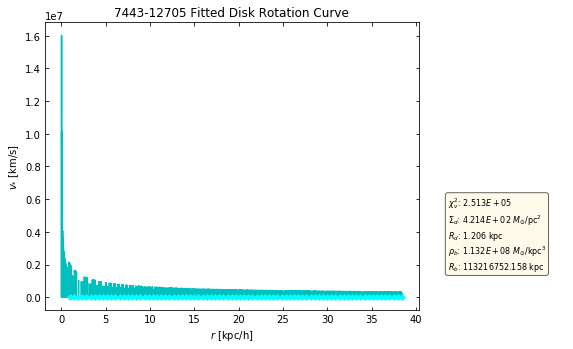

Fitting velocity map


/software/anaconda3/5.3.0/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


KeyboardInterrupt: 

In [7]:
for i in range(50):
    params = rho_h[-1], Rh[-1], axis_ratio[-1], phi[-1], x0[-1], y0[-1],  vsys[-1]
    fit = combination_fit(sMass_density, sMass_density_err, maps['r_band'], maps['vmasked'], maps['ivarmasked'], vmap_mask, \
                sM_mask, params, z, gal_ID, "NFW")
    
    x0.append(fit[8])
    y0.append(fit[9])
    axis_ratio.append(find_axis_ratio(fit[6]))
    phi.append(fit[7])
    rho_h.append(fit[4])
    Rh.append(fit[5])
    vsys.append(fit[10])
    if np.abs(x0[-2]-x0[-1])<1 and np.abs(y0[-2]-y0[-1])<1 and np.abs(phi[-2]-phi[-1])<0.00017 and \
        np.abs(axis_ratio[-2]-axis_ratio[-1])<0.001 and np.abs(vsys[-2]-vsys[-1])<0.01:
        break
    
    

In [15]:
chi2(maps['vmasked'], maps['ivarmasked'], vmap_mask, shape, scale, fit, "NFW")

(30450.40284899121, 19.19949738271829)

In [11]:
print(x0)

[37, 36.601317634646975, 36.58787688702797, 36.59054333919501, 36.5930250404196]


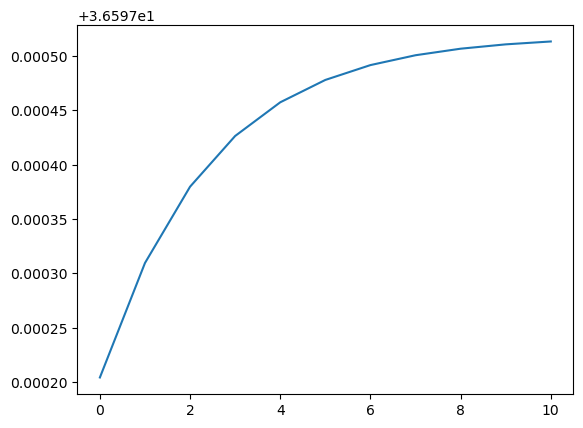

In [33]:
plt.plot(x0[10:])

In [182]:
x0diff = []
y0diff = []
phidiff = []
axis_ratiodiff = []
rho_hdiff = []
Rhdiff = []
vsysdiff = []

for i in range(51):
    print(i)
    x0diff.append(np.abs(x0[i+1]-x0[i]))
    y0diff.append(np.abs(y0[i+1]-y0[i]))
    phidiff.append(np.abs(phi[i+1]-phi[i]))
    axis_ratiodiff.append(np.abs( axis_ratio[i+1]-axis_ratio[i]))
    rho_hdiff.append(np.abs(rho_h[i+1]-rho_h[i]))
    Rhdiff.append(np.abs(Rh[i+1]-Rh[i]))
    vsysdiff.append(np.abs(vsys[i+1]-vsys[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


IndexError: list index out of range

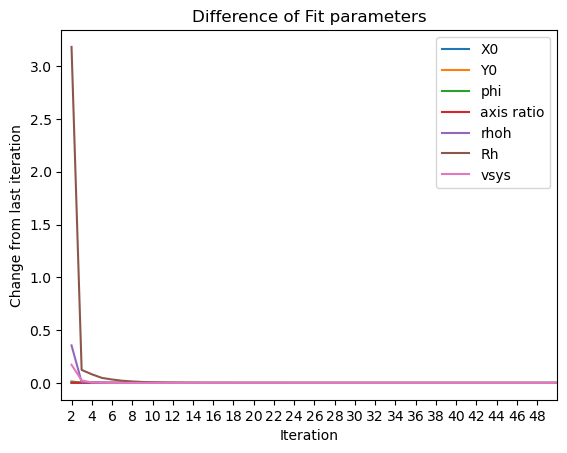

In [196]:
r = range(2,51)
plt.plot(r,x0diff[1:50])
plt.plot(r,y0diff[1:50])
plt.plot(r,phidiff[1:50])
plt.plot(r,axis_ratiodiff[1:50])
plt.plot(r,rho_hdiff[1:50])
plt.plot(r,Rhdiff[1:50])
plt.plot(r,vsysdiff[1:50])
plt.legend(['X0','Y0','phi','axis ratio', 'rhoh', 'Rh','vsys'])
plt.xticks(np.arange(0, 50, step=2))
plt.xlabel("Iteration")
plt.ylabel("Change from last iteration")
#plt.yscale('log')
plt.title('Difference of Fit parameters')
plt.xlim([1,50])
#plt.ylim([0,5])
plt.savefig('isodifferenceoffitparameters')

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

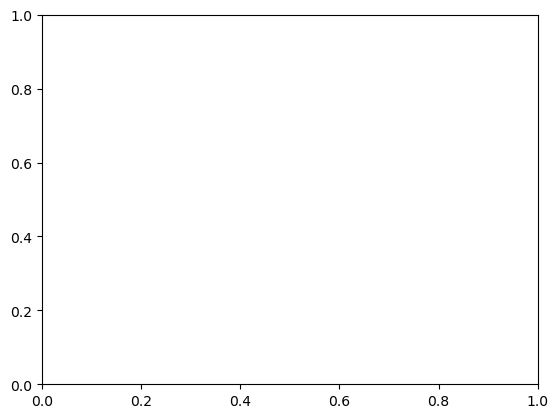

In [138]:
r = range(2,22)
plt.plot(r,x0diff)
plt.plot(r,y0diff)
plt.plot(r,phidiff)
plt.plot(r,axis_ratiodiff)
plt.plot(r,rho_hdiff)
plt.plot(r,Rhdiff)
plt.legend(['X0','Y0','phi','axis ratio', 'rhoh', 'Rh'])
plt.xticks(np.arange(0, 20, step=2))
plt.xlabel("Iteration")
plt.ylabel("Change from last iteration")
plt.xlim([15,20])
plt.ylim([0,0.001])


(0.0, 1e-12)

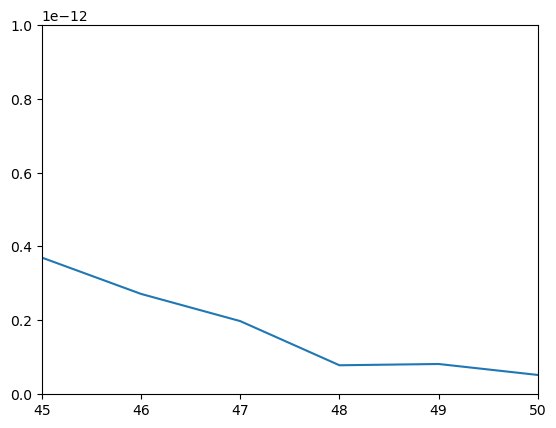

In [166]:
plt.plot(r,phidiff)
plt.xlim([45,50])
plt.ylim([0,0.000000000001])

In [167]:
print(Rhdiff)

[6.12352125883303, 3.1814734875597495, 0.12331187079152972, 0.0818750958579022, 0.04761873305826114, 0.032459732362531746, 0.020614116493641532, 0.01395633381737671, 0.009016276007210777, 0.005998569938415521, 0.00398440172970016, 0.002648339170407077, 0.0017592933496430874, 0.0011682505982770763, 0.0007755765726837893, 0.000514802772177525, 0.0003416716498803041, 0.00022674882908724214, 0.00015047347551355728, 9.985291982594902e-05, 6.626013008670384e-05, 4.396808295759058e-05, 2.9175530549707673e-05, 1.9359638590010775e-05, 1.2846173187419652e-05, 8.524112832475339e-06, 5.656190601222022e-06, 3.753174085296962e-06, 2.4904067252862205e-06, 1.6525067501049762e-06, 1.0965285994757323e-06, 7.276083229257324e-07, 4.827904529491889e-07, 3.2036764974208154e-07, 2.1256594173735266e-07, 1.4104768553124813e-07, 9.359817543241888e-08, 6.211110648024487e-08, 4.121088981179355e-08, 2.7340678165899135e-08, 1.814841699143699e-08, 1.2035449969971523e-08, 7.992803752188138e-09, 5.30229904427415e-09, 

In [168]:
print(phidiff)

[0.05510458072566127, 0.0004821988440649738, 2.4523636018791706e-05, 1.8613099993514126e-05, 1.0881835209475277e-05, 4.7956947544225415e-06, 3.22047725953567e-06, 1.4207003218302816e-06, 1.2172567744883622e-06, 7.496336301704432e-07, 4.5369785250937156e-07, 2.981043001337724e-07, 1.9644639892568705e-07, 1.2979132235635404e-07, 8.588147681898306e-08, 5.688015081162234e-08, 3.76958738668165e-08, 2.4992394487277636e-08, 1.6574554062565028e-08, 1.0994022026089567e-08, 7.293323500690008e-09, 4.838677458707252e-09, 3.2103762981350314e-09, 2.130093990082571e-09, 1.4133429981910695e-09, 9.377830734180748e-10, 6.22277784856351e-10, 4.129061537128109e-10, 2.739447557686958e-10, 1.8179990846078908e-10, 1.2065060062127486e-10, 8.006229013091115e-11, 5.3090420948365136e-11, 3.524469605054037e-11, 2.3363644352514257e-11, 1.5523915486426176e-11, 1.0285883256244688e-11, 6.86084522527608e-12, 4.5318193642174265e-12, 2.9889424268958464e-12, 2.0021762026090073e-12, 1.3158363287857355e-12, 8.9572793626757

In [169]:
difference = Table()

In [171]:
difference['x0']=x0diff
difference['y0']=y0diff
difference['phi']=phidiff
difference['axis ratio']=axis_ratiodiff
difference['Halo density']=rho_hdiff
difference['Halo scale radius']=Rhdiff

In [177]:
difference.write('iterationsdiff', format='csv', overwrite = True)

In [175]:
Table.write.list_formats()

           Format           Read Write Auto-identify Deprecated
--------------------------- ---- ----- ------------- ----------
                      ascii  Yes   Yes            No           
               ascii.aastex  Yes   Yes            No           
                ascii.basic  Yes   Yes            No           
     ascii.commented_header  Yes   Yes            No           
                  ascii.csv  Yes   Yes           Yes           
                 ascii.ecsv  Yes   Yes           Yes           
           ascii.fast_basic  Yes   Yes            No           
ascii.fast_commented_header  Yes   Yes            No           
             ascii.fast_csv  Yes   Yes            No           
       ascii.fast_no_header  Yes   Yes            No           
             ascii.fast_rdb  Yes   Yes            No           
             ascii.fast_tab  Yes   Yes            No           
          ascii.fixed_width  Yes   Yes            No           
ascii.fixed_width_no_header  Yes   Yes  

In [11]:
test = [0]